In [1]:
%reset -f

import sys
sys.path.append("../exadata-main/parquet_dataset/query_tool")

import os
import pandas as pd
import numpy as np
import itertools
import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from query_tool import M100DataClient
from matplotlib import pyplot as plt
from models import *

dataset_path = "data"
processed_path = "processed_m100"
client = M100DataClient(dataset_path)




In [2]:
import torch
import torch.nn as nn
import scipy

class LinearNN(nn.Module):
    def __init__(self, feature_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, action_dim)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

def train(model, trainloader, optimizer, loss_fn, epochs, scheduler=None, batches=-1):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    for e in range(epochs):
        # Iterating over data to carry out training step
        for ii, (inputs, labels) in enumerate(trainloader):
            if batches == ii:
                del inputs, labels
            if batches != -1 and ii >= batches:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outs = model.forward(inputs)
            outs, labels = torch.squeeze(outs), torch.squeeze(labels)
            loss = loss_fn(outs, labels)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            del inputs, labels, outs
        if scheduler:
            scheduler.step()
            if scheduler:
                scheduler.step()
        print(f"Epoch {e+1}/{epochs}, Loss: {loss.item()}")
    model.eval()

def train_epoch(model, trainloader, optimizer, loss_fn, scheduler=None, n_batches=-1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    losses = []
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        if n_batches == ii:
            del inputs, labels
            break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outs = model.forward(inputs)
        outs, labels = torch.squeeze(outs), torch.squeeze(labels)
        loss = loss_fn(outs, labels)
        losses.append(loss.detach().cpu())
        loss.backward()
        optimizer.step()
        del inputs, labels, outs
    if scheduler:
        scheduler.step()

    model.eval()
    return losses

def test_epoch(model, testloader, loss_fn, n_batches=-1):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.eval()
    losses = []
    with torch.no_grad():
        # Iterating over data to carry out training step
        for ii, (inputs, labels) in enumerate(testloader):
            if n_batches == ii:
                del inputs, labels
                break

            inputs, labels = inputs.to(device), labels.to(device)
            outs = model.forward(inputs)
            outs, labels = torch.squeeze(outs), torch.squeeze(labels)
            loss = loss_fn(outs, labels)
            losses.append(loss)
            del inputs, labels, outs

    model.eval()
    return losses

In [3]:
#TODO FOR BOTH: TIMESTAMP INDICES

def extract_node_values(feature_list, n_rows, nodes_of_interest, columns, year_month):
    node_dfs = []
    for f in feature_list: 
        query_df = client.query(f, 
                      columns=columns,
                      year_month=year_month)   
        query_df.dropna(inplace=True)
        node_list = query_df["node"].to_numpy().astype(np.int32)
        for noi in nodes_of_interest:
            idxs = np.where(node_list == noi, True, False)
            nodes = query_df.iloc[idxs].iloc[:n_rows]
            node_values = nodes["value"].values
            
            node_df = pd.DataFrame(index=nodes["timestamp"])
            new_name = str(noi) + "_" + str(f)
            node_df[new_name] = nodes["value"].values
            node_dfs.append(node_df)
            
    plugin_df=pd.concat(node_dfs, axis=1, join="inner")
    return plugin_df

def extract_values(feature_list, n_rows, columns, year_month):
    dfs = []
    for f in feature_list: 
        query_df = client.query(f, 
                      columns=columns,
                      year_month=year_month)   
        query_df.dropna(inplace=True)
        df = pd.DataFrame(index=query_df["timestamp"])
        df[f] = query_df["value"].values
        df = df.iloc[:n_rows]
        dfs.append(df)
        
    plugin_df=pd.concat(dfs, axis=1, join="inner")
    return plugin_df
    
#ipmi collects physical/hardware properties of nodes
def make_ipmi():
    ipmi_features = ["ambient"]
    ipmi_columns = ["timestamp", "node", "value"]
    ipmi_df = extract_node_values(ipmi_features, n_rows, nodes_of_interest, ipmi_columns, year_month)
    return ipmi_df

#ganglia collects metrics on utilization of hardware 
def make_ganglia():
    ganglia_features = []
    ganglia_columns = ["timestamp", "node", "value"]
    ganglia_df = extract_node_values(ganglia_features, n_rows, nodes_of_interest,ganglia_columns, year_month)
    return ganglia_df
    
#vertiv plugin collects data for AC cooling 

def make_vertiv():
    vertiv_features = ["Supply_Air_Temperature"]
    vertiv_columns = ["timestamp", "value"]
    vertiv_df = extract_values(vertiv_features, n_rows, vertiv_columns, year_month)
    return vertiv_df.groupby(vertiv_df.index).mean()

def make_vertiv_labels():
    vertiv_labels = ["Return_Air_Temperature"]
    vertiv_columns = ["timestamp", "value"]
    vertiv_labels = extract_values(vertiv_labels, n_rows, vertiv_columns, year_month)
    return vertiv_labels
   

#weather data
def make_weather():
    weather_features = ["temp"]
    weather_columns = ["timestamp", "value"]
    weather_df = extract_values(weather_features, n_rows, weather_columns, year_month)
    return weather_df

In [4]:
"""Cell purpose: pull desired features from plugins"""


n_rows = 1000000
nodes_of_interest = [i for i in range(10)]
# nodes_of_interest = [0]
year_month = ["22-02"]

vertiv_df = make_vertiv()
vertiv_df = vertiv_df
vertiv_df.to_csv(os.path.join(processed_path, "vertiv.csv"))
# 
# 
vertiv_labels = make_vertiv_labels()
vertiv_labels.to_csv(os.path.join(processed_path, "vertiv_labels.csv"))
# 
ipmi_df = make_ipmi()
ipmi_df.to_csv(os.path.join(processed_path, "ipmi.csv"))
# 
weather_df = make_weather()
weather_df.to_csv(os.path.join(processed_path, "weather.csv"))


#schneider collects data on liquid cooling system
# schneider_df = client.query(["Tot"],
#                   columns=['timestamp', 'value'],
#                   year_month=["22-02"])

# logics collects power consumption data from equipment and devices
# logics_features = ["Tot"]
# logics_columns = ["timestamp", "node", "value"]
# logics_df = extract_node_values(logics_features, n_rows, nodes_of_interest, logics_columns, year_month)
# logics_df.to_csv(os.path.join(processed_path, "logics.csv"))
# del logics_df #probably done anyway by python but no harm

Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float


In [5]:
weather_df = pd.read_csv(os.path.join(processed_path, "weather.csv"), index_col = "timestamp")
vertiv_df = pd.read_csv(os.path.join(processed_path, "vertiv.csv"), index_col="timestamp")
vertiv_labels = pd.read_csv(os.path.join(processed_path, "vertiv_labels.csv"),index_col="timestamp")
# ganglia_df= pd.read_csv(os.path.join(processed_path, "ganglia.csv"))
ipmi_df = pd.read_csv(os.path.join(processed_path, "ipmi.csv"), index_col="timestamp")


plugin_dfs = [ipmi_df, weather_df, vertiv_df, vertiv_labels] #start w/ small one for now
df = plugin_dfs[0]
for d in plugin_dfs[1:]:
    df = df.merge(d, left_index=True, right_index=True)
df

#notes: we lose a lot of measurements because timestamps do not overlap. We might want to define an acceptabel margin

,0_ambient,1_ambient,2_ambient,3_ambient,4_ambient,5_ambient,6_ambient,7_ambient,8_ambient,9_ambient,temp,Supply_Air_Temperature,Return_Air_Temperature
timestamp,,,,,,,,,,,,,
2022-02-01 00:00:00+00:00,21.8,20.8,21.6,21.6,22.2,22.2,22.0,22.4,22.8,23.2,7.10,18.733334,24.5
2022-02-01 00:00:00+00:00,21.8,20.8,21.6,21.6,22.2,22.2,22.0,22.4,22.8,23.2,7.10,18.733334,24.8
2022-02-01 00:00:00+00:00,21.8,20.8,21.6,21.6,22.2,22.2,22.0,22.4,22.8,23.2,7.10,18.733334,23.2
2022-02-01 00:00:00+00:00,21.8,20.8,21.6,21.6,22.2,22.2,22.0,22.4,22.8,23.2,7.10,18.733334,25.3
2022-02-01 00:00:00+00:00,21.8,20.8,21.6,21.6,22.2,22.2,22.0,22.4,22.8,23.2,7.10,18.733334,25.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28 23:40:00+00:00,21.2,20.4,21.4,21.6,22.4,22.2,22.2,22.4,22.8,23.2,4.59,17.566668,25.1
2022-02-28 23:40:00+00:00,21.2,20.4,21.4,21.6,22.4,22.2,22.2,22.4,22.8,23.2,4.59,17.566668,23.3
2022-02-28 23:40:00+00:00,21.2,20.4,21.4,21.6,22.4,22.2,22.2,22.4,22.8,23.2,4.59,17.566668,25.2


In [6]:
df.index[0]

'2022-02-01 00:00:00+00:00'

In [7]:
"""Cell purpose: preprocess and/or merge data as desired"""
# 
# feature_list = itertools.chain(ipmi_features, weather_features, vertiv_features)
# label_list = itertools.chain(vertiv_labels) 
feature_list = ["0_ambient", "9_ambient", "temp", "Supply_Air_Temperature"]
label_list = ["Return_Air_Temperature"]

train_df, test_df = train_test_split(df)
train_df, test_df = train_df.iloc[:-1], test_df.iloc[1:] #align t and t+1
train_features, test_features = train_df[feature_list], test_df[feature_list]
train_labels, test_labels = train_df[label_list], test_df[label_list]




In [8]:
# Will have to make work with timestamp indexign later
class M100Data(Dataset):
    def __init__(self, feature_df, label_df, transform = None, label_transform = None):
        self.feature_df = feature_df
        self.label_df = label_df
        self.feature_dim = self.feature_df.shape[1]
        self.label_dim = self.label_df.shape[1]
        self.transform = transform
        self.label_transform = label_transform
        
    def __len__(self):
        return self.feature_df.shape[0]

    def __getitem__(self, idx):
        feature = torch.as_tensor(self.feature_df.iloc[idx].values, dtype=torch.float32)
        label = torch.as_tensor(self.label_df.iloc[idx].values, dtype=torch.float32)
        return feature, label
    
train_ds = M100Data(train_features, train_labels)
trainloader = DataLoader(train_ds, batch_size = 8, shuffle = True)

test_ds = M100Data(test_features, test_labels)
testloader = DataLoader(test_ds, batch_size=2)

In [9]:
epochs = 10
model = LinearNN(train_ds.feature_dim, train_ds.label_dim)
optimizer = torch.optim.SGD(model.parameters(), 1e-3)
loss_fn = torch.nn.MSELoss()

train_losses, test_losses = [], []
for _ in range(epochs):
    train_losses.append(train_epoch(model, trainloader, optimizer, loss_fn))
    test_losses.append(test_epoch(model, testloader, loss_fn))
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

In [12]:
train_losses.shape
test_losses.shape

(10, 1593)

In [16]:
def plot_avg_epoch_loss(train_losses, test_losses):
    assert len(train_losses) == len(test_losses) #num of epochs should be the same
    avg_train_losses = np.mean(train_losses, axis=1)
    avg_test_losses = np.mean(test_losses, axis=1)
    timesteps = [t for t in range(len(avg_train_losses))]
    # colors = iter(plt.cm.viridis(np.linspace(0, 0.5, 2)))
    plt.plot(timesteps, avg_train_losses, c="blue", label="Training loss")
    plt.plot(timesteps, avg_test_losses, c="red", label="Testing loss")
    plt.legend(loc="upper left")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()



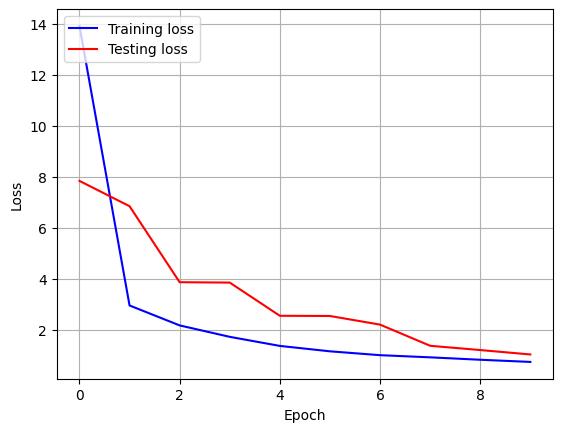

In [17]:
"""Cell purpose: benchmarking"""
plot_avg_epoch_loss(train_losses, test_losses)